# Eric Karsten PSET 4 Solutions

## 1. Feasible Function

Using the calibration from Section 2.6, write a Python function named `feasible()` that has the following form

    b_constr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)

where the inputs are a tuple `f_params = (nvec, A, alpha, delta)` and a guess for the steady statat savings vector `bvec_guess = np.array([scalar, scalar]`. The outputs should be Boolean vectors of lengths 2, 3, 1 respectively. `K_cnstr` should be True if $K \leq 0$. `c_cnstr` should be a length-3 boolean vector in which the $s$ element is True if $c_s \leq 0$. And `b_cnstr` denotes which element of the `bvec_guess` is most likely responsible for violations in `c_cnstr`. If the first element of `c_cnstr` is True, first elemet of `b_cnstr` is True. If the second element of `c_cnstr` is true, then both elements of `b_cnstr` are True. If the last element of `c_cnstr` is True, then the last element of `b_cnstr` is True.

In [1]:
import numpy as np
import scipy.optimize as opt
import scipy.interpolate as intpl
import matplotlib.pyplot as plt

# Parameter Setup
beta = 0.442
delta = 0.6415
sigma = 3
A = 1
alpha = 0.35
L = 2.2

f_params_init = (3, A, alpha, delta)

def feasible(f_params, bvec_guess):
    nvec, A_loc, alpha_loc, delta_loc = f_params
    b_2, b_3 = bvec_guess
    
    K = b_2 + b_3
    L = 2.2
    r = alpha_loc * A_loc * (L / K)**(1-alpha_loc) - delta_loc  
    w = (1 - alpha_loc) * A_loc * (K / L)**alpha_loc
    
    c_1 = w - b_2
    c_2 = w + (1 + r) * b_2 - b_3
    c_3 = 0.2 * w + (1 + r) * b_3
    
    K_cnstr = K <= 0
    c_cnstr = (c_1 <= 0, c_2 <= 0, c_3 <=0)
    b_cnstr = ((c_1 <= 0) | (c_2 <= 0),  (c_2 <= 0) | (c_3 <=0))
    
    return(b_cnstr, c_cnstr, K_cnstr)

### a.
Which, if any of the constraints is violated if you choose an initial guess for steady-state savings of `bvec_geuss = np.array([1.0, 1.2])`

In [2]:
feasible(f_params_init, np.array([1.0, 1.2]))

((True, False), (True, False, False), False)

We see that the first period consumption constraint is violated. 

### b.
Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of `bvec_geuss = np.array([0.06, -0.001])`

In [3]:
feasible(f_params_init, np.array([0.06, -0.001]))

((False, False), (False, False, False), False)

No constraints are violated here.

### c.
Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of `bvec_geuss = np.array([0.1, 0.1])`

In [4]:
feasible(f_params_init, np.array([0.1, 0.1]))

((False, False), (False, False, False), False)

It would appear that no constraints are violated here either.

## 2. Steady State Function

Write a function `get_SS()` that has the following form

    ss_output = get_SS(params, bvec_guess, SS_graphs)
    
where the inputs are a tuple of pparameters for the model

    params = (beta, sigmal, nvec, L, A, alpha, delta, SS_tol)
 
an initial guess of steady-state savings, and a Boolean indicating whether graphs should be generated for the distribution of consumption and savings. The output object `ss_output` is a Python dictionary with the steady state solution values

    ss_output = {'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
    'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
    'EUlErr_ss': EulErr_ss, 'RCer_ss': RCerrss, 'ss_time': ss_time}
  
Let `ss_time` be the number of seconds to run the steady state program and `EulErr_ss` is a length-2 vector of the two Euler erros from the steady state solution given in difference form $\beta(1 + r)u'(c_{s+1}) - u'(c_s)$. The object `RCerr_ss` is a resource constraint error which should be close to zero. It is $Y - C - \delta K$.

In [5]:
import time

params_init = (beta, sigma, 3, L, A, alpha, delta, 1e-9)

def get_SS(params, bvec_guess, SS_graphs):
    beta_loc, sigma_loc, n, L_loc, A_loc, alpha_loc, delta_loc, tol = params
    
    start_time = time.perf_counter()
    
    def r(b_2, b_3):
        K = b_2 + b_3
        return(alpha_loc * A_loc * (L_loc / K)**(1-alpha_loc) - delta_loc )
    
    def w(b_2, b_3):
        K = b_2 + b_3
        return((1 - alpha_loc) * A_loc * (K / L_loc) ** alpha_loc )
        
    def u(c):
        return((c**(1 - sigma_loc) - 1)/(1 - sigma_loc))
        
    def u_p(c):
        return(c ** (- sigma_loc))
        
    def error(b_g):
        b_2_i, b_3_i = b_g
        
        w_loc = w(b_2_i, b_3_i)
        r_loc = r(b_2_i, b_3_i)
        
        err_1 = u_p(w_loc - b_2_i) - beta_loc * (1 + r_loc) * u_p(w_loc + (1 + r_loc) * b_2_i - b_3_i)
        err_2 = u_p(w_loc + (1 + r_loc) * b_2_i - b_3_i) - beta_loc * (1 + r_loc) * u_p((1 + r_loc) * b_3_i + 0.2 * w_loc)
        return([err_1, err_2])
    
    def error_scalar(b_g):
        e_1, e_2 = error(b_g)
        return(e_1 ** 2 + e_2 ** 2)
    
    
    results = opt.minimize(error_scalar, x0 = bvec_guess, tol = tol, method = 'Nelder-Mead')
    b_2 , b_3 = results.x
    w_ss = w(b_2, b_3)
    r_ss = r(b_2, b_3)
    c_1 = w_ss - b_2
    c_2 = w_ss + (1 + r_ss) * b_2 - b_3
    c_3 = 0.2 * w_ss + (1 + r_ss) * b_3
    
    Y = A_loc * (b_2 + b_3) ** alpha_loc * L_loc ** (1 - alpha_loc)

    ss_output = {
        'b_ss': (b_2, b_3),
        'c_ss': (c_1, c_2, c_3),
        'w_ss': w_ss,
        'r_ss': r_ss,
        'K_ss': b_2 + b_3,
        'Y_ss': Y,
        'C_ss': c_1 + c_2 + c_3,
        'EUlErr_ss': error(results.x),
        'RCer_ss': Y - c_1 - c_2 - c_3 - delta_loc * (b_2 + b_3),
        'ss_time': time.perf_counter() - start_time}
    
    if SS_graphs:
        plt.plot((1,2, 3), (c_1, c_2, c_3), label='Consumption')
        plt.plot((2, 3), (b_2, b_3), label='Savings')
        plt.title('Steady State Consumption and Savings');
        plt.xlabel('Period');
        plt.legend();
        
    return(ss_output)


### a.
Solve numerically for the steady state and list those values. Also time the function.

In [6]:
get_SS(params_init, np.array([0.1, 0.1]), False)

{'b_ss': (0.019312529972129372, 0.05841109607812074),
 'c_ss': (0.1824121276882676, 0.2096146807553314, 0.24087386521881682),
 'w_ss': 0.20172465766039696,
 'r_ss': 2.4330623314882507,
 'K_ss': 0.07772362605025011,
 'Y_ss': 0.6827603797736513,
 'C_ss': 0.6329006736624159,
 'EUlErr_ss': [1.0674299346646876e-06, -2.53592290277993e-07],
 'RCer_ss': 2.0816681711721685e-17,
 'ss_time': 0.010852000000000306}

### b. 
Generate a figure that shows the steady state distirbution of consumption and savings by age.

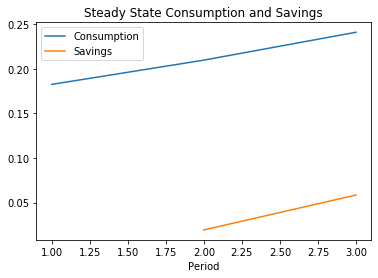

In [7]:
solution = get_SS(params_init, np.array([0.1, 0.1]), True)

### c.
What happens to each of the steady state values if all households become more patient (say $\beta = 0.55$)? What is the intuition of the change in consumption, savings, wage and interest rate?

{'b_ss': (0.028176918751888803, 0.07686545078766963),
 'c_ss': (0.19597527666990824, 0.2286159412256766, 0.2666930711647169),
 'w_ss': 0.22415219542179704,
 'r_ss': 1.8863765164563062,
 'K_ss': 0.10504236953955842,
 'Y_ss': 0.7586689691199285,
 'C_ss': 0.6912842890603017,
 'EUlErr_ss': [-5.968712457615766e-08, -8.78506199342155e-07],
 'RCer_ss': 5.551115123125783e-17,
 'ss_time': 0.007622599999999924}

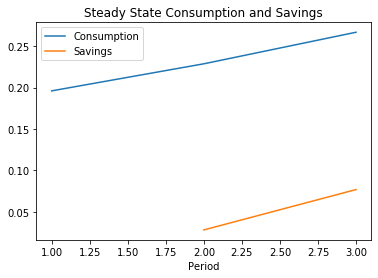

In [8]:
params_experiment = (0.55, sigma, 3, L, A, alpha, delta, 1e-9)
get_SS(params_experiment, np.array([0.1, 0.1]), True)

We see that when people become more patient, steady state consumption increases in later periods while falling slightly in earlier periods, savings incease in both periods. The steady state interest rate falls while the steady state wage rises. Intuitively, the changes in consumption make sense pecause people becoming more patient means that they should want to consume more in the future and thus will save more. Because the value of later consumption has increased, the rising wage is attributable to more demand (since labor if fixed in our model), and the rising interest rate is necessary for borrowing markets to clear between the periods.

## 3. Time Path Iteration

Use TPI to solve for the non-steady state equilibrium transition path of the economy from `(0.8 \bar b_2, 1.1 \bar b_3)` to the steady state. Choose some guess for periods `T` and path updating parameter $\xi \in (0,1)$. Use convergence parameter of $10^{-9}$. Use a linear initial guess for the time path of capital stock.

In [9]:
T = 30
xi = .1
epsilon = 1e-9

b_2_start = solution["b_ss"][0] * 0.8
b_3_start = solution["b_ss"][1] * 1.1

b_2_end = solution["b_ss"][0]
b_3_end = solution["b_ss"][1]

K_start = b_2_start + b_3_start
K_end = b_2_end + b_3_end

K_vec = np.linspace(K_start, K_end, T)
K_vec = np.append(K_vec, K_end)

def u_p(c):
    return(c ** (- sigma))

dist = 1
while dist > 1e-9:
    
    def r(K):
        return(alpha * A * (L / K)**(1-alpha) - delta )
    
    def w(K):
        return((1 - alpha) * A * (K / L) ** alpha )
    
    w_vec = [w(k) for k in K_vec]
    r_vec = [r(k) for k in K_vec]
    
    # Now solve for vector of savings in each period
    # While solving for these, store the Euler errors as a vector for each
    b_2_vec = np.zeros(T)
    b_3_vec = np.zeros(T)
    err_1_vec = np.zeros(T)
    err_2_vec = np.zeros(T)
    
    b_2_vec[0] = b_2_start
    b_3_vec[0] = b_3_start

    for i in range(1, T + 1):
        if i == 1:
            def error(b_3_t_1):
                w_t = w_vec[i - 1]
                w_t_1 = w_vec[i]
                
                r_t = r_vec[i - 1]
                r_t_1 = r_vec[i]
                
                b_2_t = b_2_vec[i - 1]
                b_3_t = b_3_vec[i - 1]
                
                err_LHS = u_p(w_t + (1 + r_t) * b_2_t - b_3_t_1)
                err_RHS = beta * (1 + r_t_1) * u_p((1 + r_t_1) * b_3_t_1 + 0.2 * w_t_1)
                return abs(err_LHS - err_RHS)
            
            per_1_sol = opt.minimize(error, x0 = 0.1,
                                     tol = epsilon * 1e-2, method = 'Nelder-Mead')
            
            b_3_vec[i] = per_1_sol.x
            err_2_vec[i] = error(per_1_sol.x)
        else:
            def error(b_next):
                b_3_t_1 , b_2_t = b_next
                b_3_t = b_3_vec[i - 1]
                
                w_t_n_1 = w_vec[i - 2]
                w_t = w_vec[i - 1]
                w_t_1 = w_vec[i]
                
                r_t = r_vec[i - 1]
                r_t_1 = r_vec[i]

                err_1_LHS = u_p(w_t_n_1 - b_2_t)
                err_1_RHS = beta * (1 + r_t) * u_p(w_t + (1 + r_t) * b_2_t - b_3_t_1)
                
                err_2_LHS = u_p(w_t + (1 + r_t) * b_2_t - b_3_t_1)
                err_2_RHS = beta * (1 + r_t_1) * u_p((1 + r_t_1) * b_3_t_1 + 0.2 * w_t_1)
                return (abs(err_1_LHS - err_1_RHS), abs(err_2_LHS - err_2_RHS))
            
            def error_scalar(b_next):
                e_1, e_2 = error(b_next)
                return(e_1 ** 2 + e_2 ** 2)
            
            general_sol = opt.minimize(error_scalar, x0 = [0.1, 0.1],
                                       tol = epsilon * 1e-2, method = 'Nelder-Mead')
            
            if i != T:
                b_3_vec[i], b_2_vec[i - 1] = general_sol.x
                err_1_vec[i - 1], err_2_vec[i] = error(general_sol.x)
            else:
                b_2_vec[i - 1] = general_sol.x[1]
                err_1_vec[i -1] = error(general_sol.x)[1]
    
    # Return K implied by savings vector
    K_new = [a + b for a, b in zip(b_2_vec, b_3_vec)]
    
    # Compute distance between implied K and old K
    K_error = [(x - y) ** 2 for x, y in zip(K_vec[0:T], K_new)]
    
    # Compute new K based on old one
    K_vec = xi * np.append(K_new, K_end) + (1 - xi) * K_vec
    dist = sum(K_error)

### a.
Report the maximum of the absolute values of all the Euler Errors across the entire time path. Also report the maximum absolute value of all the aggregate resource constraint errors $Y_t - C_t - K_{t+1} + (1-\delta) K_t$ across the entire time path.

In [10]:
# From stored Euler errors, report max of absolute value

print("Maximum Euler Error from first equation:", max(err_1_vec))
print("Maximum Euler Error from second equation:", max(err_2_vec))

# From Solved r_vec, w_vec, K_vec, compute resource constraint errors and report highest abs

Y_vec = [A * (k) ** alpha * L ** (1 - alpha) for k in K_vec[0:T]]

C_vec = [w - b_2 + w + (1 + r) * b_2 - b_3 + 0.2 * w + (1 + r) * b_3 for
         w, r, b_2, b_3 in zip(w_vec, r_vec, b_2_vec, b_3_vec)]

err_vec = [y - c - k + (1-delta) * k_1 for y, c, k, k_1 in
           zip(Y_vec, C_vec, K_vec[1:(T +1)], K_vec[0:T])]

print("Maximum Resource Constraint Eror", max([abs(v) for v in err_vec]))


Maximum Euler Error from first equation: 2.9085811092954827e-08
Maximum Euler Error from second equation: 4.2970256686203356e-08
Maximum Resource Constraint Eror 0.004328938589455118


### b.
Plot the equilibrium time paths of the aggregte capital shock, wage, and interest rate.

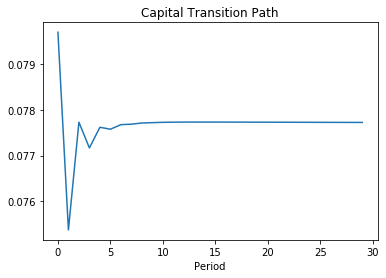

In [11]:
plt.plot(range(0,T), K_vec[0:T], label='Capital')    
plt.title('Capital Transition Path');
plt.xlabel('Period');

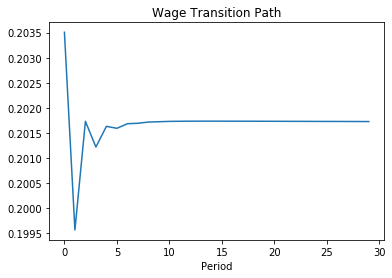

In [12]:
plt.plot(range(0,T), w_vec[0:T], label='Wage')
plt.title('Wage Transition Path');
plt.xlabel('Period'); 

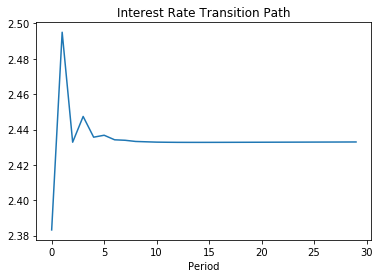

In [13]:
plt.plot(range(0,T), r_vec[0:T], label='Interest Rate')
plt.title('Interest Rate Transition Path');
plt.xlabel('Period'); 

### c.
How many periods did it take for the economy to get within 1e-5 of the steady-state aggregate capital stock? What is the period after which the aggregate capital stock never is again further than 1e-5 away from the steady-state?

In [14]:
t = [abs(k - K_end) < 1e-5 for k in K_vec]
true_inds = [i for i, x in enumerate(t) if x]
false_inds = [i for i, x in enumerate(t) if not x]
print("First period when economy close to steady state is", min(true_inds) + 1)
print("First period when economy permanantly close to steady state is", max(false_inds) + 2)

First period when economy close to steady state is 3
First period when economy permanantly close to steady state is 19
